In [1]:
import anndata
import numpy as np
import pandas as pd
import networkx as nx
import random
import scanpy as sc
import scglue
import tqdm
from matplotlib import rcParams
from matplotlib.pyplot import rc_context

In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [3]:
concern_cell_type = ['Astro', 'Endo', 'ODC', 'OPC']

In [4]:
hic = anndata.read_h5ad("/home/micl/workspace/lmh_data/Lee2019/scHiC.h5ad")

hic.obs_names = hic.obs_names.str.split(r"[:_]").map(lambda x: '_'.join(x[:-2]))
hic.obs["cell_type"] = hic.obs_names.str.split(r"[:_]").map(lambda x: x[5])
hic = hic[hic.obs['cell_type'].isin(concern_cell_type),:]
hic

View of AnnData object with n_obs × n_vars = 2102 × 309581
    obs: 'domain', 'cell_type'
    var: 'chrom', 'start'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


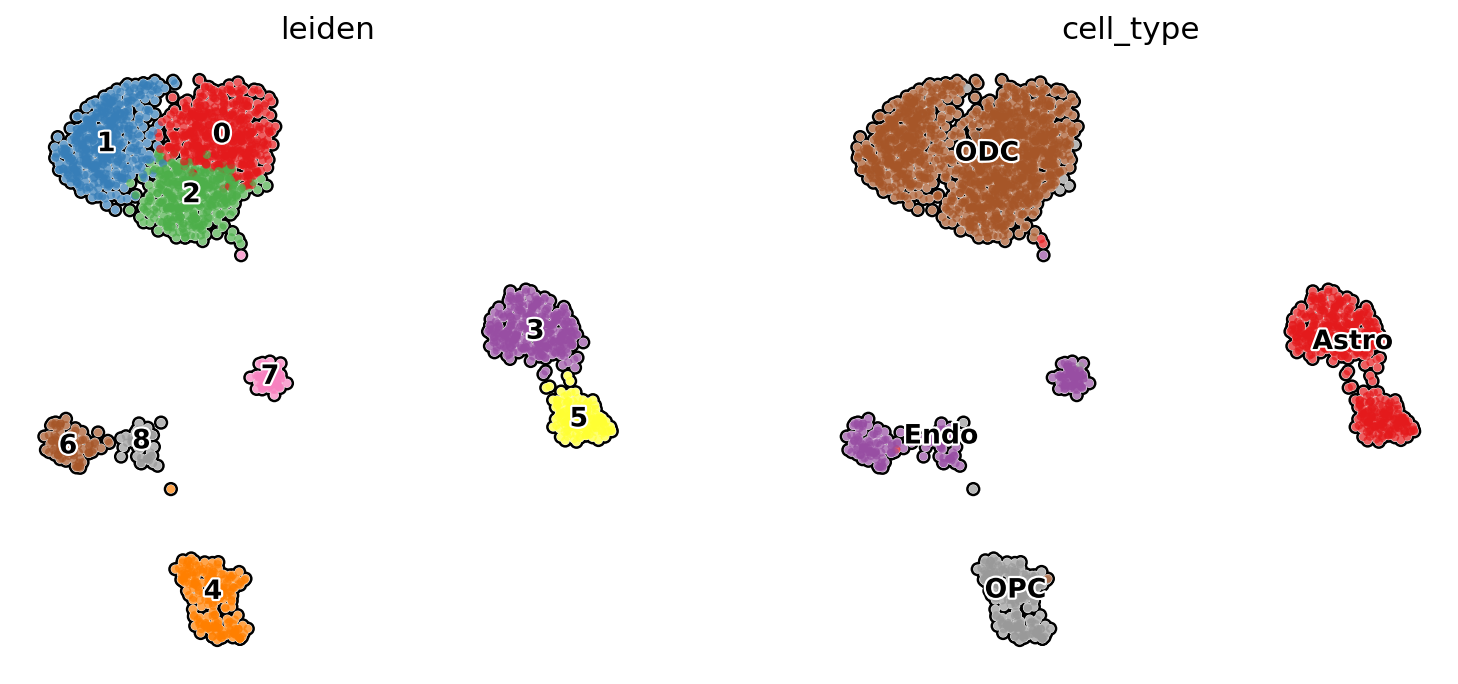

In [5]:
hic_pca = pd.read_csv('/home/micl/workspace/lmh_data/Lee2019/BandNorm/embedding.txt', sep='\t')
hic_pca.index = hic_pca.index.str.split(".").map(lambda x: x[0])
hic_pca = hic_pca.loc[hic.obs.index]
hic.obsm["X_pca"] = hic_pca.to_numpy()

def hic_pca():
    sc.pp.neighbors(hic, use_rep="X_pca", metric="cosine")
    sc.tl.umap(hic)
    sc.tl.leiden(hic)
hic_pca()
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(hic, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


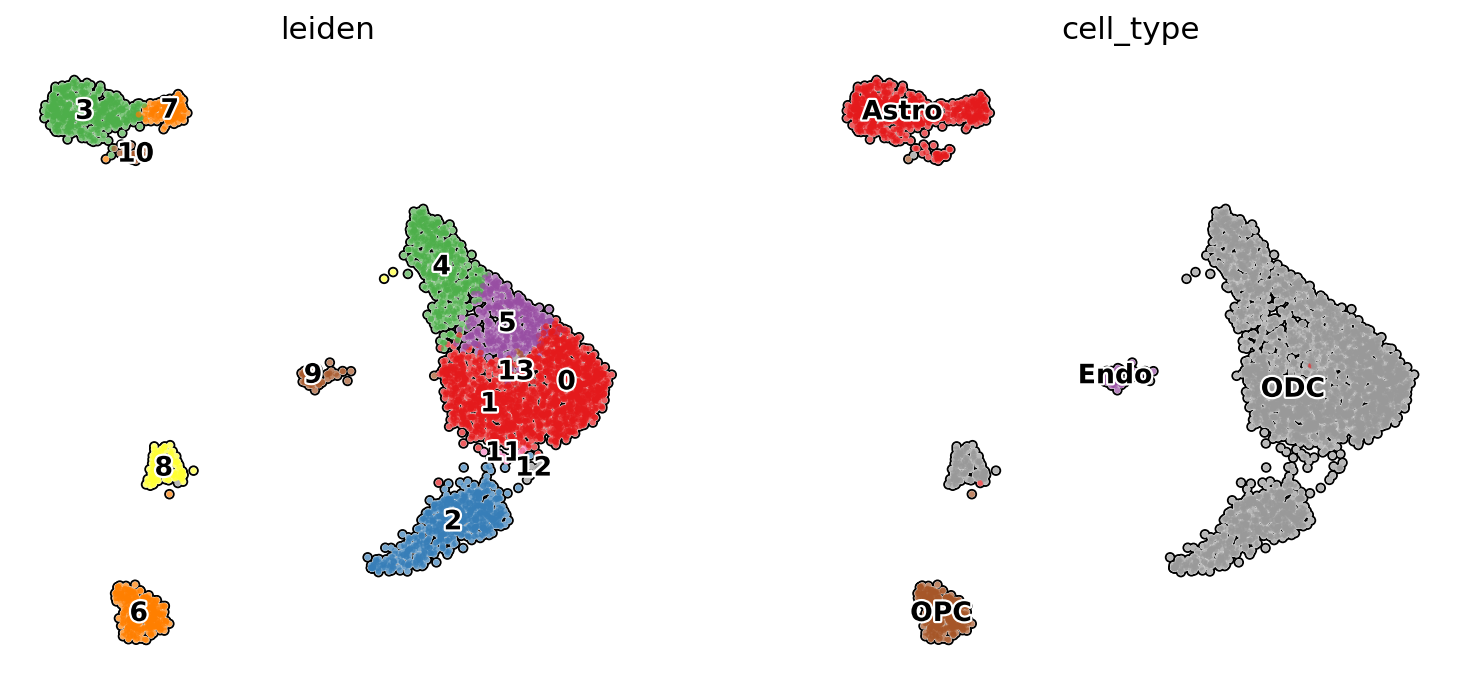

In [6]:
rna = anndata.read_h5ad("/home/micl/workspace/lmh_data/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})
rna = rna[rna.obs['cell_type'].isin(concern_cell_type),:]
rna.layers["counts"] = rna.X.copy()

scglue.data.get_gene_annotation(
    rna, gtf="/home/micl/workspace/lmh_data/public/gencode.v19.annotation.gtf",
    gtf_by="gene_name"
)
rna = rna[:, rna.var.dropna(axis=0, how='all').index]

def rna_pca(rna):
    rna.X = rna.layers["counts"].copy()
    sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
    sc.pp.normalize_total(rna)
    sc.pp.log1p(rna)
    sc.pp.scale(rna)
    sc.tl.pca(rna, n_comps=100, svd_solver="auto")

    sc.pp.neighbors(rna, metric="cosine")
    sc.tl.umap(rna)
    sc.tl.leiden(rna)
rna_pca(rna)
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

In [7]:
# hic = hic[hic.obs['leiden'].isin(['0', '1', '2', '3', '4', '5', '7']),:].copy()
rna = rna[~rna.obs['leiden'].isin(['2', '8', '10']),:].copy()

In [8]:
rna.var

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,...,transcript_name,havana_gene,tag,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
DDX11L1,chr1,11868.0,14412.0,DDX11L1,.,+,.,.,.,.,...,DDX11L1,OTTHUMG00000000961.2,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
WASH7P,chr1,14362.0,29806.0,WASH7P,.,-,.,.,.,.,...,WASH7P,OTTHUMG00000000958.1,NaN,False,NaN,0.005704,0.006192,0.989308,0.003778,0.05347
MIR1302-2,chr9,27656.0,30891.0,MIR1302-2,.,+,.,.,.,.,...,MIR1302-2,OTTHUMG00000019418.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
FAM138A,chr1,34553.0,36081.0,FAM138A,.,-,.,.,.,.,...,FAM138A,OTTHUMG00000000960.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
OR4G4P,chr1,52472.0,54936.0,OR4G4P,.,+,.,.,.,.,...,OR4G4P,OTTHUMG00000185779.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TPTE2P4,chrY,28654359.0,28725837.0,TPTE2P4,.,+,.,.,.,.,...,TPTE2P4,OTTHUMG00000036765.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
SLC25A15P1,chrY,28732788.0,28737748.0,SLC25A15P1,.,-,.,.,.,.,...,SLC25A15P1,OTTHUMG00000036811.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
PARP4P1,chrY,28740997.0,28780799.0,PARP4P1,.,-,.,.,.,.,...,PARP4P1,OTTHUMG00000036812.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
FAM58CP,chrY,28772666.0,28773306.0,FAM58CP,.,-,.,.,.,.,...,FAM58CP,OTTHUMG00000036813.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000


In [9]:
# random.seed(0)
# for cell_type in concern_cell_type:
#     hic_count = hic[hic.obs['cell_type'].isin([cell_type]),:].shape[0]
#     rna_count = rna[rna.obs['cell_type'].isin([cell_type]),:].shape[0]
#     if rna_count == hic_count:
#         continue
#     other_cell_type = list(set(concern_cell_type) - set([cell_type]))
#     if rna_count > hic_count:
#         _count = min(int(hic_count), rna_count)
#         tmp = rna[rna.obs['cell_type'].isin([cell_type]),:].copy()
#         tmp = tmp[random.sample(range(0, rna_count), _count), :]
#         rna = anndata.concat([rna[rna.obs['cell_type'].isin(other_cell_type),:], tmp])
#     else:
#         _count = min(int(rna_count), hic_count)
#         tmp = hic[hic.obs['cell_type'].isin([cell_type]),:].copy()
#         tmp = tmp[random.sample(range(0, hic_count), _count), :]
#         hic = anndata.concat([hic[hic.obs['cell_type'].isin(other_cell_type),:], tmp])

In [10]:
hic.var['chrom'] = [info[0] for info in hic.var_names.str.split('_')]
hic.var['chromStart'] = [int(info[1]) for info in hic.var_names.str.split('_')]
hic.var['chromEnd'] = hic.var['chromStart'] + 10000
hic.var

,chrom,start,chromStart,chromEnd
chr1_0,chr1,0,0,10000
chr1_10000,chr1,10000,10000,20000
chr1_20000,chr1,20000,20000,30000
chr1_30000,chr1,30000,30000,40000
chr1_40000,chr1,40000,40000,50000
...,...,...,...,...
chrY_59330000,chrY,59330000,59330000,59340000
chrY_59340000,chrY,59340000,59340000,59350000
chrY_59350000,chrY,59350000,59350000,59360000
chrY_59360000,chrY,59360000,59360000,59370000


In [11]:
# hic_pca()
# with rc_context({'figure.figsize': (5, 5)}):
#     sc.pl.umap(hic, color=['cell_type'], add_outline=True, legend_loc='on data',
#                legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

In [12]:
# rna_pca(rna)
# with rc_context({'figure.figsize': (5, 5)}):
#     sc.pl.umap(rna, color=['cell_type'], add_outline=True, legend_loc='on data',
#                legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

In [13]:
# scglue.data.get_gene_annotation(
#     rna, gtf="/home/micl/workspace/lmh_data/public/gencode.v19.annotation.gtf",
#     gtf_by="gene_name"
# )
# rna = rna[:, rna.var.dropna(axis=0, subset=['chrom', 'chromStart']).index]
# rna.var

In [14]:
sc.tl.rank_genes_groups(rna, 'cell_type', method='t-test')
marker_genes = pd.DataFrame(rna.uns['rank_genes_groups']['names'])[:1000]
marker_genes_index = marker_genes.values.reshape(-1)
_index = set(rna.var[rna.var['highly_variable']==True].index) & set(marker_genes_index)
rna.var['highly_variable'] = False
rna.var.loc[_index, 'highly_variable'] = True
rna.var

/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/liminghong/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/tmp/ipykernel_1787557/767983501.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  rn

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,...,transcript_name,havana_gene,tag,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
DDX11L1,chr1,11868.0,14412.0,DDX11L1,.,+,.,.,.,.,...,DDX11L1,OTTHUMG00000000961.2,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
WASH7P,chr1,14362.0,29806.0,WASH7P,.,-,.,.,.,.,...,WASH7P,OTTHUMG00000000958.1,NaN,False,NaN,0.005704,0.006192,0.989308,0.003778,0.05347
MIR1302-2,chr9,27656.0,30891.0,MIR1302-2,.,+,.,.,.,.,...,MIR1302-2,OTTHUMG00000019418.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
FAM138A,chr1,34553.0,36081.0,FAM138A,.,-,.,.,.,.,...,FAM138A,OTTHUMG00000000960.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
OR4G4P,chr1,52472.0,54936.0,OR4G4P,.,+,.,.,.,.,...,OR4G4P,OTTHUMG00000185779.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TPTE2P4,chrY,28654359.0,28725837.0,TPTE2P4,.,+,.,.,.,.,...,TPTE2P4,OTTHUMG00000036765.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
SLC25A15P1,chrY,28732788.0,28737748.0,SLC25A15P1,.,-,.,.,.,.,...,SLC25A15P1,OTTHUMG00000036811.1,NaN,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
PARP4P1,chrY,28740997.0,28780799.0,PARP4P1,.,-,.,.,.,.,...,PARP4P1,OTTHUMG00000036812.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000
FAM58CP,chrY,28772666.0,28773306.0,FAM58CP,.,-,.,.,.,.,...,FAM58CP,OTTHUMG00000036813.1,pseudo_consens,False,NaN,0.000000,0.000000,0.000000,0.000000,1.00000


In [15]:
import collections
import pybedtools

from pybedtools.cbedtools import Interval
from scglue.check import check_deps
from scglue.genomics import Bed
from scglue.utils import smart_tqdm
from typing import Any, Callable, Mapping, Optional, Union

def interval_dist(x: Interval, y: Interval) -> int:
    r"""
    Compute distance and relative position between two bed intervals

    Parameters
    ----------
    x
        First interval
    y
        Second interval

    Returns
    -------
    dist
        Signed distance between ``x`` and ``y``
    """
    if x.chrom != y.chrom:
        return np.inf * (-1 if x.chrom < y.chrom else 1)

    _start1, _end1 = (x.stop, x.start) if x.strand == '-' else (x.start, x.stop)
    _start2, _end2 = (y.stop, y.start) if y.strand == '-' else (y.start, y.stop)
    
    d = _start1-_start2
#     d = min(abs(_start1-_start2), abs(_end1-_start2))
#     if abs(d) <= 10000:
#         d = 0

    x_range = set([i for i in range(int(x.start/10000)*10000, int(x.end/10000)*10000+10000, 10000)])
    y_range = set([i for i in range(y.start, y.end+10000, 10000)])
    if x_range&y_range:
        d = 0

    return d
        
#     if x.start < y.stop and y.start < x.stop:
#         return 0
#     if x.stop <= y.start:
#         return x.stop - y.start - 1
#     if y.stop <= x.start:
#         return x.start - y.stop + 1

def window_graph(
        left: Union[Bed, str], right: Union[Bed, str], window_size: int,
        left_sorted: bool = False, right_sorted: bool = False,
        attr_fn: Optional[Callable[[Interval, Interval, float], Mapping[str, Any]]] = None
) -> nx.MultiDiGraph:
    r"""
    Construct a window graph between two sets of genomic features, where
    features pairs within a window size are connected.

    Parameters
    ----------
    left
        First feature set, either a :class:`Bed` object or path to a bed file
    right
        Second feature set, either a :class:`Bed` object or path to a bed file
    window_size
        Window size (in bp)
    left_sorted
        Whether ``left`` is already sorted
    right_sorted
        Whether ``right`` is already sorted
    attr_fn
        Function to compute edge attributes for connected features,
        should accept the following three positional arguments:

        - l: left interval
        - r: right interval
        - d: signed distance between the intervals

        By default no edge attribute is created.

    Returns
    -------
    graph
        Window graph
    """
    check_deps("bedtools")
    if isinstance(left, Bed):
        pbar_total = len(left)
        left = left.to_bedtool()
    else:
        pbar_total = None
        left = pybedtools.BedTool(left)
    if not left_sorted:
        left = left.sort(stream=True)
    left = iter(left)  # Resumable iterator
    if isinstance(right, Bed):
        right = right.to_bedtool()
    else:
        right = pybedtools.BedTool(right)
    if not right_sorted:
        right = right.sort(stream=True)
    right = iter(right)  # Resumable iterator

    attr_fn = attr_fn or (lambda l, r, d: {})
    if pbar_total is not None:
        left = smart_tqdm(left, total=pbar_total)
    graph = nx.MultiDiGraph()
    window = collections.OrderedDict()  # Used as ordered set
    searched_chrom = set()
    for l in left:
        searched_chrom.add(l.chrom)
        for r in list(window.keys()):  # Allow remove during iteration
            if r.chrom != l.chrom and r.chrom in searched_chrom:
                del window[r]
                continue
            d = interval_dist(l, r)
            if -window_size <= d <= window_size:
                graph.add_edge(l.name, r.name, **attr_fn(l, r, d))
        else:
            for r in right:  # Resume from last break
                d = interval_dist(l, r)
                window[r] = None
                if np.isinf(d):
                    break
                if -window_size <= d <= window_size:
                    graph.add_edge(l.name, r.name, **attr_fn(l, r, d))
    pybedtools.cleanup()
    return graph

import itertools
import networkx as nx

rna_bed = scglue.genomics.Bed(rna.var.assign(name=rna.var_names))
hic_bed = scglue.genomics.Bed(hic.var.assign(name=hic.var_names))

rna_bed = rna_bed.expand(5000, 0)

def _dist_power_decay(x: int) -> float:
    return ((x + 10000) / 10000) ** (-0.75)
graph = window_graph(
    rna_bed, hic_bed, window_size=10000,
    attr_fn=lambda l, r, d, s=1: {
        "dist": abs(d), "weight": _dist_power_decay(abs(d)), "sign": s
    }
)

rgraph = graph.reverse()
nx.set_edge_attributes(graph, "fwd", name="type")
nx.set_edge_attributes(rgraph, "rev", name="type")
graph = scglue.graph.compose_multigraph(graph, rgraph)

hvg_reachable = scglue.graph.reachable_vertices(graph, rna.var.query("highly_variable").index)
hic.var["highly_variable"] = [
    item in hvg_reachable for item in hic.var_names
]

all_features = set(itertools.chain.from_iterable(
    map(lambda x: x.var_names, [rna, hic])
))
for item in all_features:
    graph.add_edge(item, item, weight=1.0, sign=1, type="loop")

  0%|          | 0/29175 [00:00<?, ?it/s]

In [16]:
graph.number_of_nodes(), graph.number_of_edges()

(338756, 791312)

In [17]:
all(graph.has_node(gene) for gene in rna.var_names), \
all(graph.has_node(peak) for peak in hic.var_names), \
all(graph.has_edge(gene, gene) for gene in rna.var_names), \
all(graph.has_edge(peak, peak) for peak in hic.var_names), \
all(graph.has_edge(j, i) for i, j, _ in graph.edges)

(True, True, True, True, True)

In [18]:
hic.var.head()

,chrom,start,chromStart,chromEnd,highly_variable
chr1_0,chr1,0,0,10000,False
chr1_10000,chr1,10000,10000,20000,False
chr1_20000,chr1,20000,20000,30000,False
chr1_30000,chr1,30000,30000,40000,False
chr1_40000,chr1,40000,40000,50000,False


In [19]:
rna.write("/home/micl/workspace/lmh_data/sclab/rna_preprocessed.h5ad", compression="gzip")
hic.write("/home/micl/workspace/lmh_data/sclab/hic_preprocessed.h5ad", compression="gzip")
nx.write_graphml(graph, "/home/micl/workspace/lmh_data/sclab/prior.graphml.gz")